<a href="https://colab.research.google.com/github/UNT-CSCE-Projects/US_stock_market_prediction/blob/ml-farhan/Optiver_Trading_at_the_close_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Optiver - Trading at the Close
## Predict US stocks closing movements

# Data import

In [ ]:
import os.path
import json

api_token = {"username":"farhanarrafi","key":"5d6fda1adf219a27359ba81c70803e9a"}


if not os.path.isdir('/root/.kaggle'):
  ! mkdir ~/.kaggle
  ! touch ~/.kaggle/kaggle.json
  with open('/root/.kaggle/kaggle.json', 'w') as file:
      json.dump(api_token, file)
  !chmod 600 ~/.kaggle/kaggle.json

In [ ]:

if not os.path.isfile('train.csv'):
  ! kaggle competitions download -c 'optiver-trading-at-the-close'
  ! unzip optiver-trading-at-the-close.zip
  ! rm -rf optiver-trading-at-the-close.zip
  ! rm -rf sample_data/

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.pipeline import Pipeline


train_dataset = pd.read_csv('train.csv')
train_dataset_row_17 = train_dataset[train_dataset['stock_id'] == 17]
train_dataset_row_17.tail(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5235997,17,480,450,9149818.35,-1,0.996902,59289903.31,0.948306,0.971091,0.996817,57056.96,0.997052,276931.68,0.996857,7.590056,26445,480_450_17
5236197,17,480,460,4254932.96,-1,0.997520,64184788.69,0.996114,0.996412,0.997371,6083.22,0.997606,19190.05,0.997428,0.209808,26446,480_460_17
5236397,17,480,470,548463.63,-1,0.997478,67891258.03,0.997115,0.997286,0.997435,103421.37,0.997712,10766.30,0.997686,-0.780225,26447,480_470_17
5236597,17,480,480,138406.13,1,0.997968,69163656.11,0.998032,0.998032,0.997712,49150.50,0.997968,9364.40,0.997927,-0.920296,26448,480_480_17
5236797,17,480,490,175001.65,1,0.997861,69187583.95,0.998032,0.997925,0.997648,93614.00,0.997925,566990.20,0.997688,0.890493,26449,480_490_17
5236997,17,480,500,175001.65,1,0.997861,69187583.95,0.998032,0.997925,0.997712,60384.90,0.997925,422316.40,0.997739,2.239943,26450,480_500_17
5237197,17,480,510,235525.01,1,0.997798,69187583.95,0.998032,0.997819,0.997627,195649.08,0.997861,397944.50,0.997704,0.519752,26451,480_510_17
5237397,17,480,520,1377962.08,1,0.997520,69187583.95,0.998032,0.997563,0.997371,2807.64,0.997563,297667.08,0.997373,3.570318,26452,480_520_17
5237597,17,480,530,235525.01,1,0.997755,69187583.95,0.998032,0.997776,0.997584,10296.88,0.997776,273856.05,0.997591,5.029440,26453,480_530_17
5237797,17,480,540,235525.01,1,0.997755,69187583.95,0.998032,0.997776,0.997691,77702.94,0.997755,73494.84,0.997724,-2.920031,26454,480_540_17


# Data Preprocessing

In [ ]:
train = train_dataset_row_17.drop(axis='columns', columns=['stock_id', 'date_id','seconds_in_bucket','imbalance_size','imbalance_buy_sell_flag', 'reference_price','matched_size','far_price', 'near_price','bid_price','bid_size','ask_price','ask_size','wap','row_id'])
train = train.set_index('time_id')

In [ ]:
standard_deviation = train['target'].std()
standard_deviation

8.592792472682557

In [ ]:
mean = train['target'].mean()
mean

0.06302402054991493

In [ ]:
max = train['target'].max()
max

81.29001

In [ ]:
min = train['target'].min()

<Axes: >

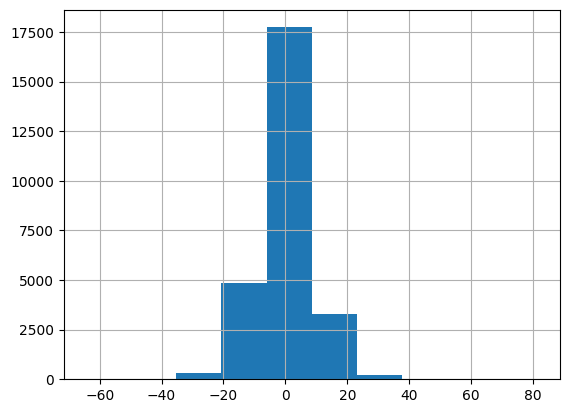

In [ ]:

train['target'].hist()

In [ ]:
# train_with_positive_outlier = train[train['target'] >= (mean + standard_deviation*3)]
# train_with_negative_outlier = train[train['target'] <= (mean + standard_deviation*3)]
# train_without_outlier = train - train_with_positive_outlier
# train_without_outlier = train - train_with_negative_outlier
# train_without_outlier['target'].hist()

In [ ]:
train.tail(5)

,target
time_id,
26450,2.239943
26451,0.519752
26452,3.570318
26453,5.029440
26454,-2.920031


# Visualisation

<Axes: title={'center': 'Plot of target value of Stock 17 for the first 1 minute'}, xlabel='Time in 10 seconds interval', ylabel='Target value of stock'>

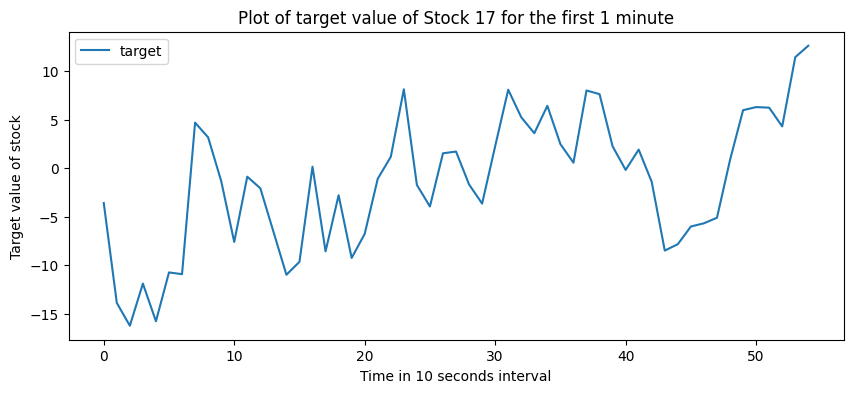

In [ ]:
start = 0 # start of day 1
end = 55 # end of day 1 -> 6(one reading each 10 seconds) * 9 minutes

train[0:55].plot(xlabel='Time in 10 seconds interval', ylabel='Target value of stock', figsize=(10,4), title='Plot of target value of Stock 17 for the first 1 minute')

# Seasonality Analysis

## Seasonal-Trend decomposition using LOESS (STL)
[Seasonal Decomposition](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html)

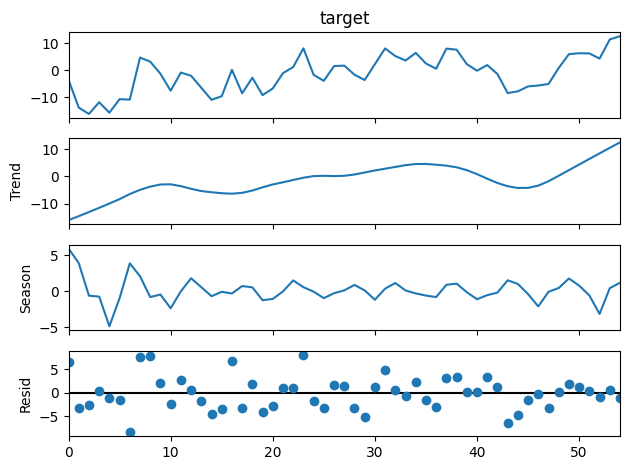

In [ ]:
from statsmodels.tsa.seasonal import STL

start = 0 # start of day 1
end = 55 # end of day 1 -> 6(one reading each 10 seconds) * 9 minutes

stl = STL(train['target'][start:end], period=6)
res = stl.fit()
fig = res.plot()

## Multiple Seasonality Decomposition

[Multiple Seasonality Decomposition](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.MSTL.html)

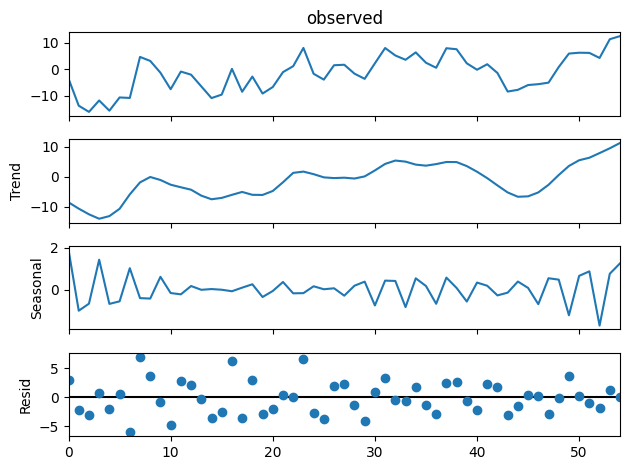

In [ ]:
from statsmodels.tsa.seasonal import MSTL

start = 0 # start of day 1
end = 55 # end of day 1 -> 6(one reading each 10 seconds) * 9 minutes

mstl = MSTL(train['target'][start:end], periods=3, iterate=2)
res = mstl.fit()
fig = res.plot()

# Trend Extracting (Moving Average)

## Simple Moving Average

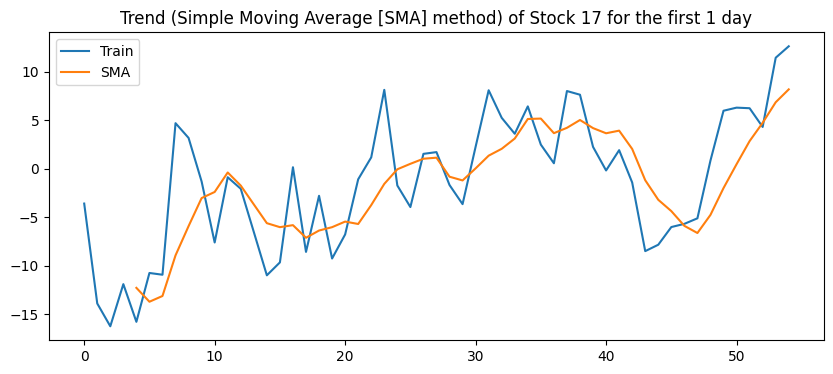

In [ ]:
import matplotlib.pyplot as plt

start = 0 # start of day 1
end = 55 # end of day 1 -> 6(one reading each 10 seconds) * 9 minutes


moving_average = train[start:end].rolling(window=5).mean()

y1 = train['target']
y2 = moving_average

plt.figure(figsize=(10,4))
plt.title('Trend (Simple Moving Average [SMA] method) of Stock 17 for the first 1 day')
plt.plot(y1[start:end], label='Train')
plt.plot(y2[start:end], label='SMA')
plt.legend()
plt.show()


## Weighted Moving Average

In [ ]:
weights = [0.1,0.2,0.3,0.4]
weighted_moving_average = train['target'][start:end].rolling(4).apply(lambda x: sum(weights*x) / sum(weights), raw=True)

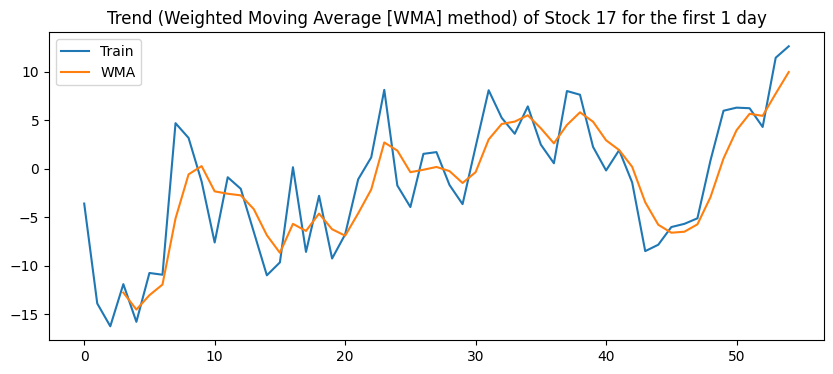

In [ ]:
start = 0 # start of day 1
end = 55 # end of day 1 -> 6(one reading each 10 seconds) * 9 minutes

y1 = train['target']
y2 = weighted_moving_average


plt.figure(figsize=(10,4))
plt.title('Trend (Weighted Moving Average [WMA] method) of Stock 17 for the first 1 day')
plt.plot(y1[start:end], label='Train')
plt.plot(y2[start:end], label='WMA')
plt.legend()
plt.show()

In [ ]:
# Exponential Smoothing (Exponential Moving Average)
exponential_smoothing_1 = train[start:end].ewm(span=4, adjust=False).mean()
exponential_smoothing_2 = exponential_smoothing_1.ewm(span=4, adjust=False).mean()
exponential_smoothing_3 = exponential_smoothing_2.ewm(span=4, adjust=False).mean()

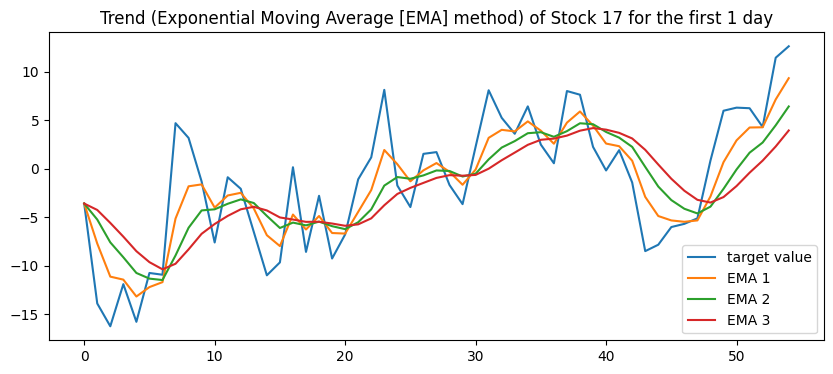

In [ ]:
y1 = train
y2 = exponential_smoothing_1
y3 = exponential_smoothing_2
y4 = exponential_smoothing_3

start = 0
end = 55

plt.figure(figsize=(10,4))
plt.title('Trend (Exponential Moving Average [EMA] method) of Stock 17 for the first 1 day')
plt.plot(y1[start:end], label = 'target value')
plt.plot(y2[start:end], label='EMA 1')
plt.plot(y3[start:end], label='EMA 2')
plt.plot(y4[start:end], label='EMA 3')
plt.legend()
plt.show()

# De-Trending the time series

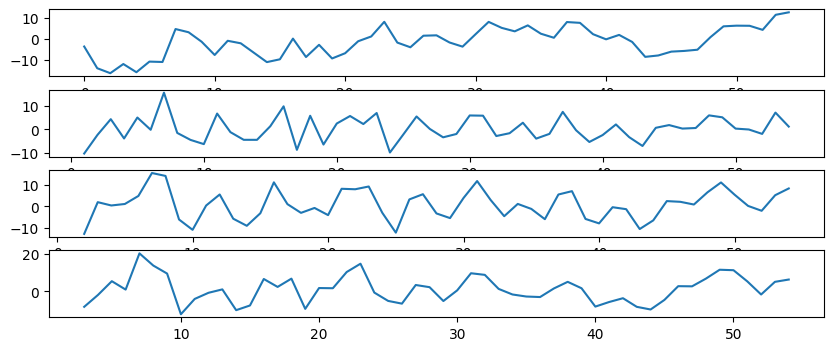

In [ ]:
start = 0
end = 55

y1 = train[start:end]
y2 = train[start:end].diff(1)
y3 = train[start:end].diff(2)
y4 = train[start:end].diff(3)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10,4))
#title('De-trending of Stock 17 for the first 1 minute')
ax1.plot(y1[start:end], label='target value')
ax2.plot(y2[start:end], label='1 Differenced')
ax3.plot(y3[start:end], label='2 Differenced')
ax4.plot(y4[start:end], label='3 Differenced')
#plt.legend()
plt.show()

# ACF for finding Q value

[Finding P, D, Q](https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/)

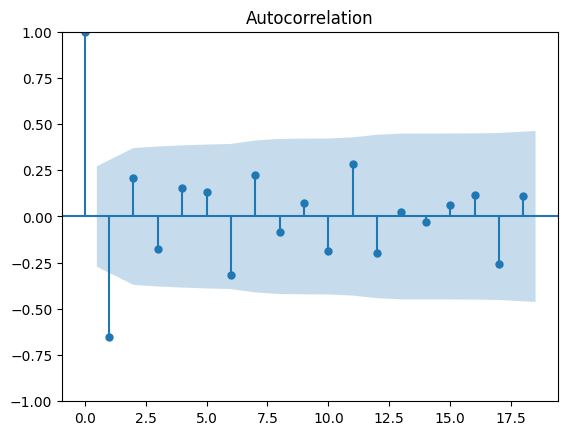

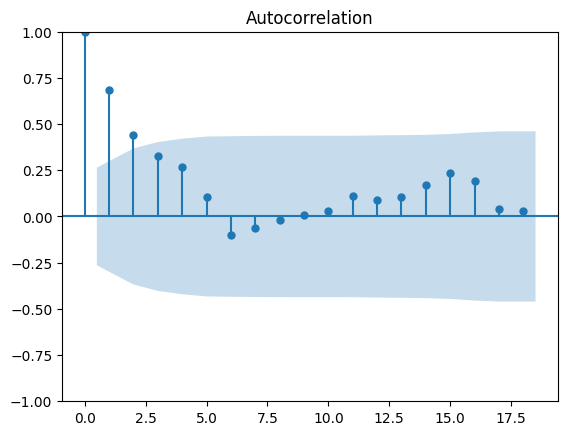

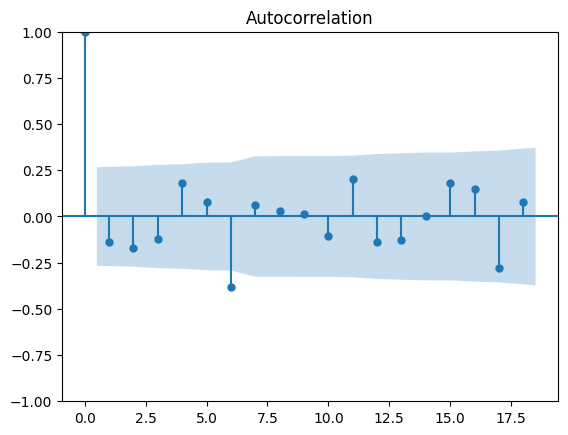

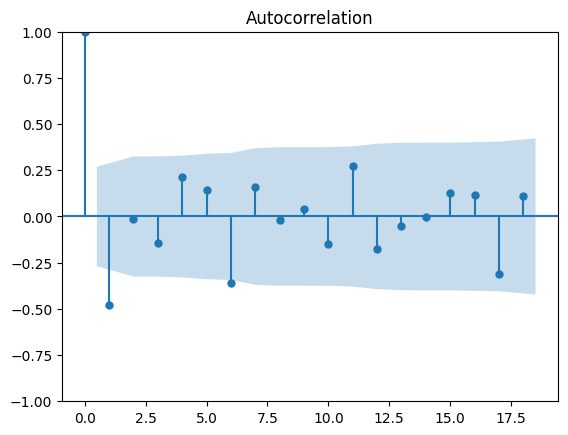

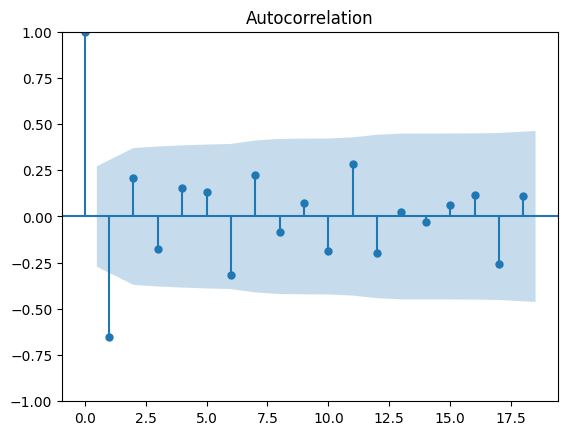

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10,4))
plot_acf(train[start:end])
plot_acf(train[start:end].diff().dropna())
plot_acf(train[start:end].diff().diff().dropna())
plot_acf(train[start:end].diff().diff().diff().dropna())

# PACF for finding P value

We ignore lag 1.

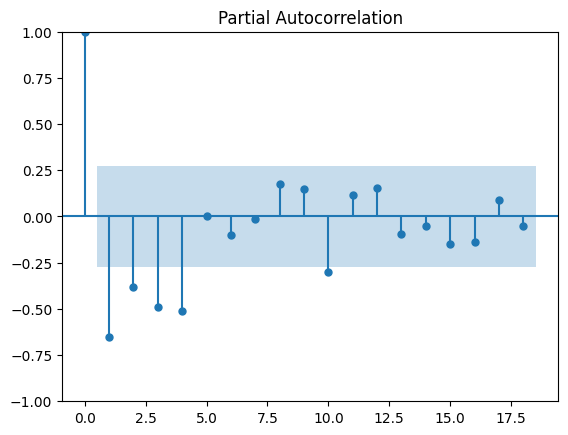

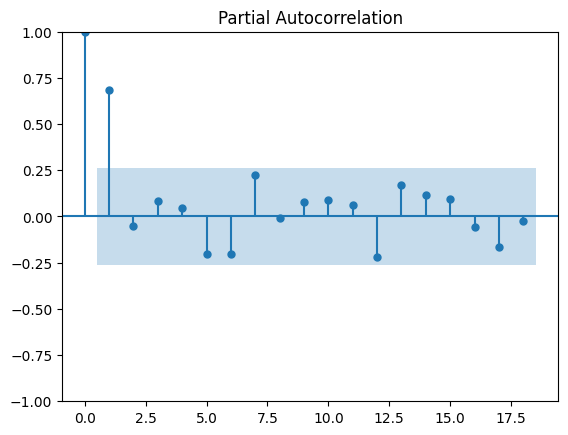

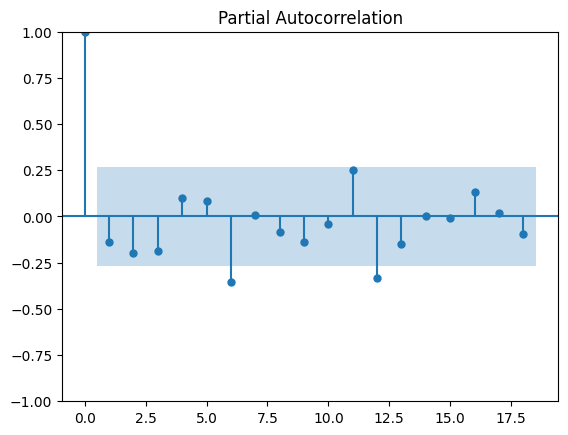

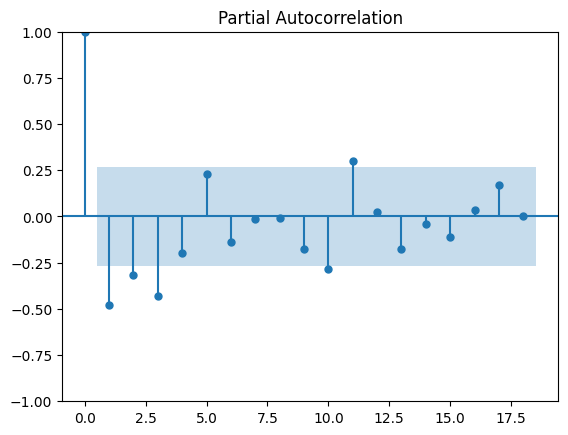

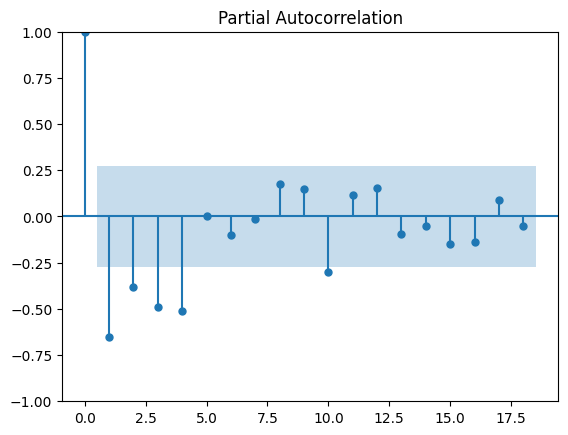

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf


# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10, 4))
plot_pacf(train[start:end])
plot_pacf(train[start:end].diff().dropna())
plot_pacf(train[start:end].diff().diff().dropna())
plot_pacf(train[start:end].diff().diff().diff().dropna())

In [ ]:
detrended_target1 = train - exponential_smoothing_1
detrended_target2 = train - exponential_smoothing_2
detrended_target3 = train - exponential_smoothing_3

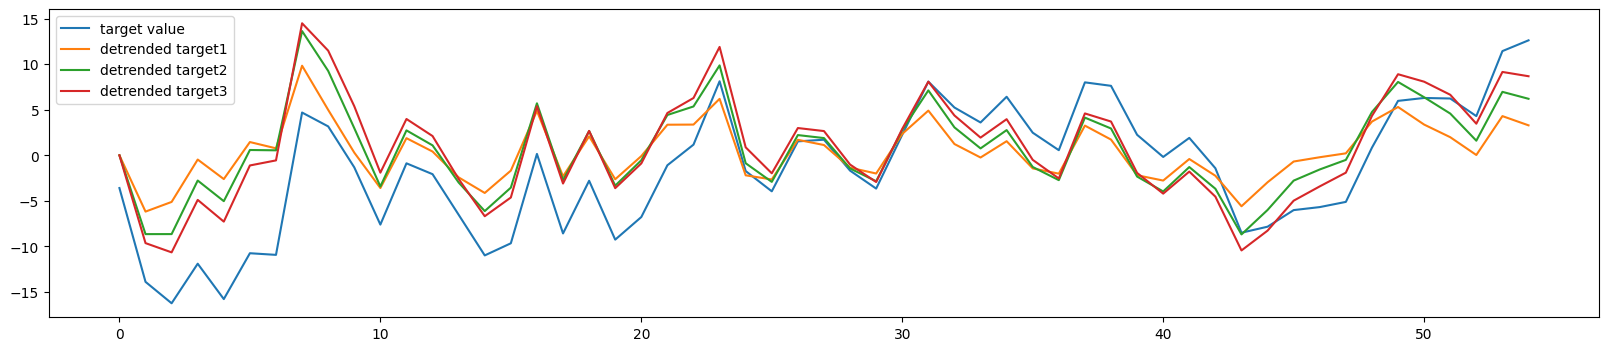

In [ ]:

start = 0
end = 55

y1 = train
y2 = detrended_target1
y3 = detrended_target2
y4 = detrended_target3

plt.figure(figsize=(20,4))
plt.plot(y1[start:end], label='target value')
plt.plot(y2[start:end], label='detrended target1')
plt.plot(y3[start:end], label='detrended target2')
plt.plot(y4[start:end], label='detrended target3')
plt.legend()
plt.show()

# plt.figure(figsize=(20,4))
# plt.plot(x[541:1080],y2[541:1080], label='detrended target')
# plt.legend()
# plt.show()

# Testing for stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

start = 0
end = 55

lag= 1
regression = 'c'

adfuller_es = adfuller(train[start:end], maxlag=lag, autolag=None, regression=regression)

adfuller_diff1 = adfuller(train[start:end].diff().dropna(), maxlag=lag, autolag=None, regression=regression)
adfuller_diff2 = adfuller(train[start:end].diff().diff().dropna(), maxlag=lag, autolag=None, regression=regression)
adfuller_diff3 = adfuller(train[start:end].diff().diff().diff().dropna(), maxlag=lag, autolag=None, regression=regression)

labels = ['ADF test statistics', 'P-value', '#Lags used', 'Number of observation used']

def parseAdfResult(adfResult):
  for value, label in zip(adfResult, labels):
    print(label+' : '+str(value))
  if adfResult[1] <= 0.05:
    print('Data is stationary')
  else:
    print('Data is non stationary.')

print(parseAdfResult(adfuller_es))
print(parseAdfResult(adfuller_diff1))
print(parseAdfResult(adfuller_diff2))
print(parseAdfResult(adfuller_diff3))

ADF test statistics : -2.492941277117412
P-value : 0.11720124847129576
#Lags used : 1
Number of observation used : 53
Data is non stationary.
None
ADF test statistics : -6.8039095521806665
P-value : 2.201423168447548e-09
#Lags used : 1
Number of observation used : 52
Data is stationary
None
ADF test statistics : -8.79293050602405
P-value : 2.215404470112563e-14
#Lags used : 1
Number of observation used : 51
Data is stationary
None
ADF test statistics : -9.750124377809076
P-value : 8.057437275573755e-17
#Lags used : 1
Number of observation used : 50
Data is stationary
None


# ADF and KPSS Test comparison
  Reference: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [ ]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    #dftest = adfuller(timeseries, autolag="AIC")
    dftest = adfuller(timeseries, maxlag=lag, autolag=None)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

print(adf_test(train[start:end]))
# print(adf_test(exponential_smoothing_1[start:end]))
# print(adf_test(exponential_smoothing_2[start:end]))
# print(adf_test(exponential_smoothing_3[start:end]))

Results of Dickey-Fuller Test:
Test Statistic                 -2.492941
p-value                         0.117201
#Lags Used                      1.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64
None


In [ ]:
from statsmodels.tsa.stattools import kpss

start = 0
end = 55

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

print(kpss_test(train[start:end].dropna()))
print(kpss_test(train[start:end].diff().dropna()))
print(kpss_test(train[start:end].diff().diff().dropna()))
print(kpss_test(train[start:end].diff().diff().diff().dropna()))

Results of KPSS Test:
Test Statistic           0.635788
p-value                  0.019383
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.126659
p-value                  0.100000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None
Results of KPSS Test:
Test Statistic            0.500000
p-value                   0.041667
Lags Used                52.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None
Results of KPSS Test:
Test Statistic            0.106784
p-value                   0.100000
Lags Used                11.000000
Critical Value (10%)      

<ipython-input-73-df6421431866>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
<ipython-input-73-df6421431866>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


# ARIMA (Auto Regression Integrated Moving Average

### Guides:
1. [ARIMA PDQ Value Selection](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_internet.html)
2. [SARIMAX Into](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)
3. [Seasonality in time series data](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_seasonal.html)
4. [Multiple Seasonal-Trend decomposition using LOESS](https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html)
5. [Seasonal-Trend decomposition using LOESS](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html)
6. [Autoregressions](https://www.statsmodels.org/dev/examples/notebooks/generated/autoregressions.html)

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.graphics.tsaplots import plot_predict

# start = 0
# end = 55

# # arima_train = ARIMA(train[start:end], order=(4, 1, 5)).fit()
# # arima_exp1 = ARIMA(exponential_smoothing_3[start:end], order=(4, 1, 5)).fit()

# arima_train = ARIMA(train[start:end-4], order=(1, 1, 3)).fit()
# arima_diff1 = ARIMA(train[start:end-4].diff(), order=(1, 1, 3)).fit()



[Model Pickling](https://medium.com/@maziarizadi/pickle-your-model-in-python-2bbe7dba2bbb)

In [ ]:
# import pickle

# pickle.dump(arima_diff1, open('ARIMA_DIFF1.pkl','wb'))



In [ ]:
# # Error calculation

# forecast = arima_train.predict(end-4, end-1, dynamic=True)
# test = train[end-4: end]
# # Compute the mean square error
# mse = ((forecast.to_frame().predicted_mean - test.target) ** 2).mean()
# # print(mse)

# baseline_mae = (forecast.to_frame().predicted_mean - test.target).abs().mean()
# print('MAE ARIMA Train: ', baseline_mae)

# forecast = arima_diff1.predict(end-4, end-1, dynamic=True)
# test = train[end-4: end]
# # Compute the mean square error
# mse = ((forecast.to_frame().predicted_mean - test.target) ** 2).mean()
# # print(mse)

# baseline_mae = (forecast.to_frame().predicted_mean - test.target).abs().mean()
# print('MAE ARIMA EXP3: ', baseline_mae)

MAE ARIMA Train:  7.427531546391954
MAE ARIMA EXP3:  8.668238232109788


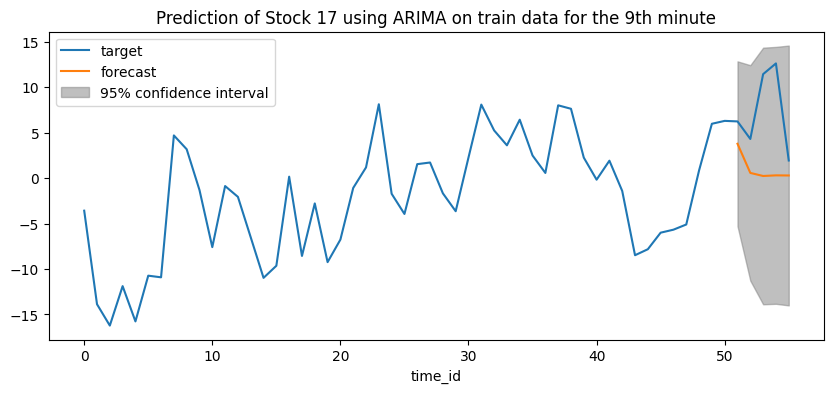

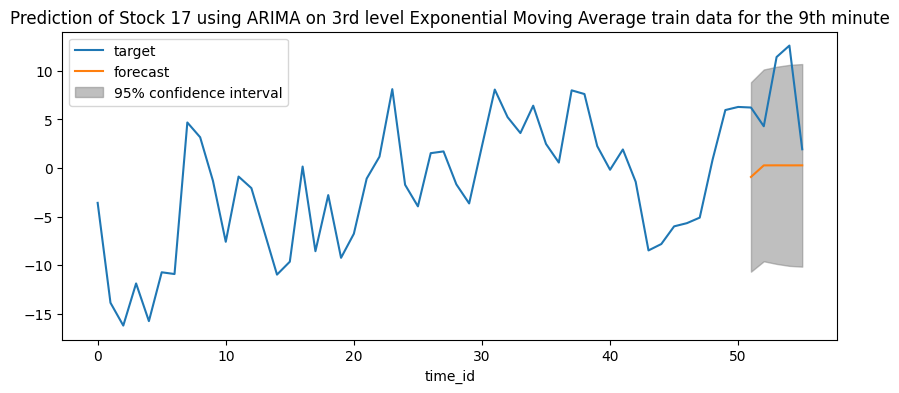

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 4))
# plt.title('Prediction of Stock 17 using ARIMA on train data for the 9th minute')
# ax = train.loc[start:end].plot(ax=ax)
# fig = plot_predict(arima_train, end-4, end, dynamic=True, ax=ax)
# plt.show()

# fig, ax = plt.subplots(figsize=(10, 4))
# plt.title('Prediction of Stock 17 using ARIMA on 3rd level Exponential Moving Average train data for the 9th minute')
# ax = train.loc[start:end].plot(ax=ax)
# fig = plot_predict(arima_diff1, end-4, end, dynamic=True, ax=ax)
# plt.show()

In [ ]:
# print(arima_train.summary())
# print(arima_train.params)

In [ ]:
# print(arima_diff1.summary())
# print(arima_diff1.params)

In [ ]:
# from statsmodels.graphics.tsaplots import plot_predict

# start = 0
# end = 55


# arma_train = ARIMA(train[start:end-9], order=(1, 0, 1)).fit()
# arma_diff1 = ARIMA(exponential_smoothing_3[start:end-9], order=(1, 0, 1)).fit()
# arma_train = ARIMA(train[start:end-4], order=(1, 0, 3)).fit()
# arma_diff1 = ARIMA(train[start:end-4].diff(), order=(1, 0, 3)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import pickle

pickle.dump(arma_diff1, open('ARMA_DIFF1.pkl','wb'))

In [ ]:
# Error calculation

start = 0
end = 55

forecast = arma_train.predict(end-4, end-1, dynamic=True)
test = train[end-4: end]
# Compute the mean square error
mse = ((forecast.to_frame().predicted_mean - test.target) ** 2).mean()
print(forecast)

print('MAE ARMA Train: ', baseline_mae)

day = 1

start = (day -1) * 55
end = day * 55

forecast = arma_diff1.predict(end-4, end-1, dynamic=True)
test = train[end-4: end]
# Compute the mean square error
mse = ((forecast.to_frame().predicted_mean - test.target) ** 2).mean()
# print(mse)

baseline_mae = (forecast.to_frame().predicted_mean - test.target).abs().mean()
print('MAE ARMA DIFF1: ', baseline_mae)
# simple_prediction_mae = (train['simple_prediction'] - train['target']).abs().mean()

# print(baseline_mae)
# print('MAE improvement in basis points: ', (baseline_mae-simple_prediction_mae))


51    2.909905
52   -1.310466
53   -2.412962
54   -2.073416
Name: predicted_mean, dtype: float64
MAE ARMA Train:  9.269367769335874
MAE ARMA DIFF1:  9.269367769335874


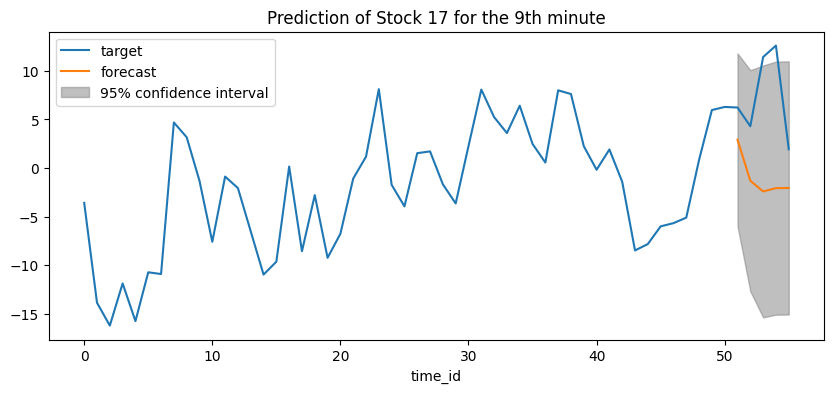

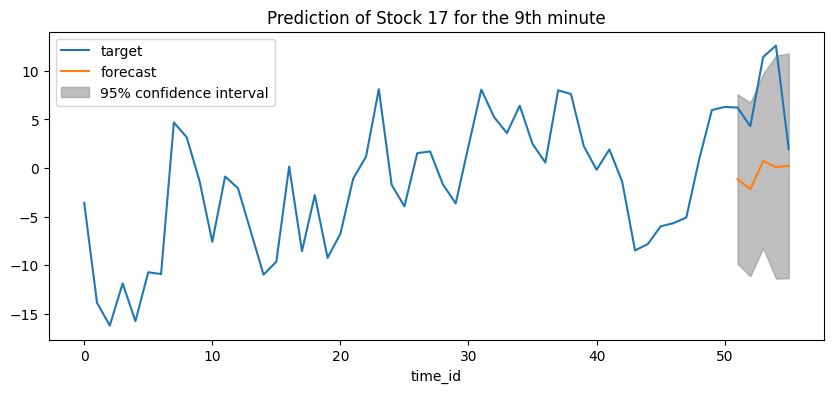

In [ ]:

# fig, ax = plt.subplots(figsize=(10, 4))
# plt.title('Prediction of Stock 17 for the 9th minute')
# ax = train.loc[start:end].plot(ax=ax)
# fig = plot_predict(arma_train, end-4, end, dynamic=True, ax=ax)
# plt.show()


# fig, ax = plt.subplots(figsize=(10, 4))
# plt.title('Prediction of Stock 17 for the 9th minute')
# ax = train.loc[start:end].plot(ax=ax)
# fig = plot_predict(arma_diff1, end-4, end, dynamic=True, ax=ax)
# plt.show()

# Testing

Exception: ignored

# References:


1.   [Testing code source](https://www.kaggle.com/code/jirkaborovec/optiver-eda-pytorch-models)
2.   [Moving Average source](https://medium.com/@HalderNilimesh/applied-data-science-for-beginners-how-to-calculate-moving-average-using-pandas-dataframe-in-7e5f7944c07a)

